In [45]:
import numpy as np
from sklearn import tree
import pandas as pd
from econml.dml import CausalForestDML as CausalForest
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from econml.cate_interpreter import SingleTreeCateInterpreter
from econml.dml import LinearDML
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

data_1 = pd.read_csv(
    "data_normalized_fr.csv"
)
data_1

,Unnamed: 0.1,Unnamed: 0,login,sufficiency_1,sufficiency_2,sufficiency_3,sufficiency_4,sufficiency_5,A,X2,...,Q1_1,Q1_1_treat,Q1_2,Q1_2_treat,Q2_1,Q2_1_treat,Q2_2,Q2_2_treat,country_residence,opinion_migration
0,0,0.000000,0.000000,1.00,0.25,0.00,1.00,0.75,0.919255,0.909758,...,0.50,0.0,0.50,0.0,0.50,0.0,0.75,0.0,0.000000,0.666667
1,1,0.000776,0.000195,1.00,1.00,0.25,0.50,0.75,0.386646,0.376376,...,0.00,0.0,0.00,0.0,0.50,0.0,1.00,0.0,0.000000,0.333333
2,2,0.001553,0.001954,1.00,0.25,0.50,1.00,0.75,0.749224,0.741746,...,1.00,0.0,1.00,0.0,0.00,0.0,0.00,0.0,0.000000,1.000000
3,3,0.003106,0.003322,0.25,0.25,0.50,0.50,0.00,0.680124,0.674248,...,0.50,1.0,0.25,1.0,0.75,1.0,0.75,1.0,0.666667,0.333333
4,4,0.003882,0.003712,0.25,0.25,0.50,0.25,0.50,0.885093,0.876009,...,0.50,0.0,0.50,0.0,0.75,0.0,0.50,0.0,1.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,907,0.995342,0.996092,1.00,0.25,1.00,1.00,0.75,0.833851,0.824652,...,1.00,1.0,1.00,1.0,0.25,1.0,1.00,1.0,0.000000,0.333333
908,908,0.996118,0.996288,1.00,0.25,0.00,1.00,0.00,0.148292,0.146001,...,0.75,1.0,0.75,1.0,0.50,1.0,0.75,1.0,0.000000,0.333333
909,909,0.997671,0.996874,0.25,0.25,1.00,1.00,0.75,0.827640,0.818782,...,0.50,0.0,0.75,0.0,0.50,0.0,0.50,0.0,1.000000,1.000000
910,910,0.999224,0.998632,1.00,1.00,0.50,0.25,0.75,0.676242,0.669112,...,0.75,1.0,0.75,1.0,0.50,1.0,0.50,1.0,0.000000,0.666667


In [46]:
y_1 = data_1["Q1_1"]
z_1 = data_1["Q1_1_treat"].astype(int)

y_2 = data_1["Q1_2"]
z_2 = data_1["Q1_2_treat"].astype(int)

y_3 = data_1["Q2_1"]
z_3 = data_1["Q2_1_treat"].astype(int)

y_4 = data_1["Q2_2"]
z_4 = data_1["Q2_2_treat"].astype(int)


# siguiendo la teoria se podria dar menos o mas validez a climate por ejemplo?
data_1["trust_in_science"] = (0.33*data_1["trustscientists_1"]) + (0.33*data_1["trustscientists_2"]) + (0.33*data_1["trustscientists_3"])
data_1["trust_in_institutions"] = (0.25*data_1["trustinst_1"]) + (0.25*data_1["trustinst_2"]) + (0.25*data_1["trustinst_3"]) + (0.25*data_1["trustinst_4"])

# genero masculinity trait... asumo que este chico no volteo los valores porque la matriz de correlacion es extrana
data_1['masculinity_46_inv'] = 1.00 - data_1['masculinity_46']
data_1['masculinity_40_inv'] = 1.00 - data_1['masculinity_40']
data_1['masculinity_41_inv'] = 1.00 - data_1['masculinity_41']

data_1["CW_var"] = (0.2*data_1["masculinity_46_inv"]) + (0.2*data_1["masculinity_42"]) + (0.2*data_1["masculinity_45"]) + (0.2*data_1["masculinity_1"]) + (0.2*data_1["masculinity_44"])
# hacemos tambien el AA aunque la variable de 41 esta mal
data_1["AA_var"] = (0.2*data_1["masculinity_40_inv"]) + (0.2*data_1["masculinity_41_inv"]) + (0.2*data_1["masculinity_39"]) + (0.2*data_1["masculinity_43"]) + (0.2*data_1["masculinity_47"])
data_1["persistency"] = (0.2*data_1["masculinity_39"]) + (0.2*data_1["masculinity_43"])

# creo mi female como yo creo que deberia ser: junto los NA con los females (en vez de con los males)
data_1['female_created'] = np.where(data_1['female2'].isin([1.0, np.nan]), 1.0, 0.0)

# voy a generar un medidor de influence in general de society
data_1["influence_society"] = (0.33*data_1["influencegeneral_6"]) + (0.33*data_1["influencegeneral_7"]) + (0.33*data_1["influencegeneral_8"])

# armamos tambien una escala de world issues, una conjunta de todas y una donde migracion fue la mas alta
columns_wi = ["worldissues_6", "worldissues_1", "worldissues_2", "worldissues_3", "worldissues_4", "worldissues_5", "worldissues_7", "worldissues_8"]
data_1['migration_importance'] = data_1.apply(lambda row: 1 if row['worldissues_6'] == row[columns_wi].max() else 0, axis=1)
# los 6 y 7 veo que su distribucion es deeeeeemasiado diferente al resto
data_1["world_issues"] = (0.125*data_1["worldissues_1"]) + (0.125*data_1["worldissues_2"]) + (0.125*data_1["worldissues_3"]) + (0.125*data_1["worldissues_4"]) + (0.125*data_1["worldissues_5"]) + (0.125*data_1["worldissues_6"]) + (0.125*data_1["worldissues_7"]) + (0.125*data_1["worldissues_8"])

# genere una variable nueva para residence2, porque note que el extra era tb de luxemburgo

# ver que hacer con income, si no quitarlo
#quite: employment, residence2
# acabo de incluir housepeople (no se como armar este indice...), igual estaria bueno hacer un indice de esto? no se..
# quito las big five de forma individual: "bigfive_1", "bigfive_1", "bigfive_2", "bigfive_3", "bigfive_4", "bigfive_5", "bigfive_6", "bigfive_7", "bigfive_8", "bigfive_9", "bigfive_10"

# hasta aca, tenemos bien la Q1, generaremos ahora una variable para marielboatlift
#"opinion_migration":
#   es 1 para personas que creian que los migrates no tenian efecto
#   es 2para los que creian que afectaba solo low income
#   es 3 para los que no saben
#   es 4 para los que creian que afectaba a todos
# esta variable ayuda solo a las Q3 y Q4

# como 'extremist' no funciono y 'climatedesobidience_1' explica demasiado, vamos a intentar generar una variable
# que sume agreement con taxes, climate desobidience y bans.
# data_1['extremist'] = np.where(data_1['climatedesobedience_1'].isin([0.0, 0.1, 0.9, 1.0]), 1, 0)
data_1["policy_preferences"] = (0.20*data_1["climatedesobedience_1"]) + (0.20*data_1["carbontax1"]) + (0.20*data_1["cartax_w1"]) + (0.20*data_1["meattax_w1"]) + (0.20*data_1["housingtax_w1"])

# quitare "renewenergy" y agregare longlisbeh_w1_*  como medidor de acciones verdes
data_1["longlistbeh_score"] = (0.1*data_1["longlistbeh_w1_1"]) + (0.1*data_1["longlistbeh_w1_2"]) + (0.1*data_1["longlistbeh_w1_3"]) + (0.1*data_1["longlistbeh_w1_4"]) + (0.1*data_1["longlistbeh_w1_5"]) + (0.1*data_1["longlistbeh_w1_6"]) + (0.1*data_1["longlistbeh_w1_7"]) + (0.1*data_1["longlistbeh_w1_8"]) + (0.1*data_1["longlistbeh_w1_9"]) + (0.1*data_1["longlistbeh_w1_10"])




covariates_names = ["country_residence", "age", "female_created", "education", "financialwellbeing", "urban", "houseowner", 
                    #"housepeople_14", "housepeople_2", "housepeople_3", "housepeople_4", "housepeople_5", "housepeople_6",
                    #"worldissues_6", "worldissues_1", "worldissues_2", "worldissues_3", "worldissues_4", "worldissues_5", "worldissues_7", "worldissues_8",
                    "migration_importance", "world_issues",
                    "policy_preferences", "confidence", "bonusdonation_w1", # esta de bonus donation asi solano me convence
                    "trust_in_science", "trust_in_institutions",
                    "trustclimatechange1", "persconcern", "perspriority_3",
                    "masculinity_40_inv", "masculinity_41_inv", "persistency","masculinity_47", "CW_var",
                    "influence_society", "influencegeneral_4", "influencegeneral_3",
                    "openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                    "Positive_Reciprocity", "Negative_Reciprocity", "Altruism", "Trust", "Risk_Preferences", "Time_Preferences", 
                    "ProcrastinationExPost", "ProcrastinationExAnte", "rationality_score", 
                    "Social_Anxiety", "Public_SelfConsciousness", "Private_SelfConsciousness",
                    "empathic_concern_score", "growthmind", "opinion_migration"]



In [47]:
# Nada forget it, hacemos mail...
basic_list = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences"]

final_list_1 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "empathic_concern_score", "Negative_Reciprocity",
                "country_residence", "age", "female_created", "education", "financialwellbeing"
                ]

final_list_2 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "empathic_concern_score", "Negative_Reciprocity",
                "trustclimatechange1", "persconcern", "perspriority_3"
                ]

final_list_3 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "empathic_concern_score", "Negative_Reciprocity",
                "longlistbeh_score", "persconcern", "perspriority_3"
                ]

final_list_4 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3"
                ]

final_list_5 = ["world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3",
                "empathic_concern_score", "Negative_Reciprocity"
                ]

final_list_6 = ["world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "empathic_concern_score", "Negative_Reciprocity",
                "country_residence", "age", "female_created", "education", "financialwellbeing"
                ]

# VOY POR AQUI, hay algo raro y es que en la lksta 8 me esperaba que Q1 perdiera todo, pero no. Quiza probar lista 1 con 40, 60
final_list_7 = ["world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "empathic_concern_score", "Negative_Reciprocity",
                ]

final_list_8 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "empathic_concern_score", "Negative_Reciprocity",
                "trustclimatechange1", "persconcern", "perspriority_3"
                ]

final_list_9 = ["empathic_concern_score", "Negative_Reciprocity",
                "country_residence", "age", "female_created", "education", "financialwellbeing"]


test_list_1 = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3", "marielboatlift"
                ]

the_chosen_one = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3"]


list_with_extra_var = ["preference_type", "openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3"]

x_cov = data_1[list_with_extra_var]

I will generate new variables to check if they help explain something

In [49]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

model_1_0 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_1, z_1, X=x_cov)

model_2_0 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_2, z_2, X=x_cov)

model_3_0 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_3, z_3, X=x_cov)

model_4_0 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_4, z_4, X=x_cov)


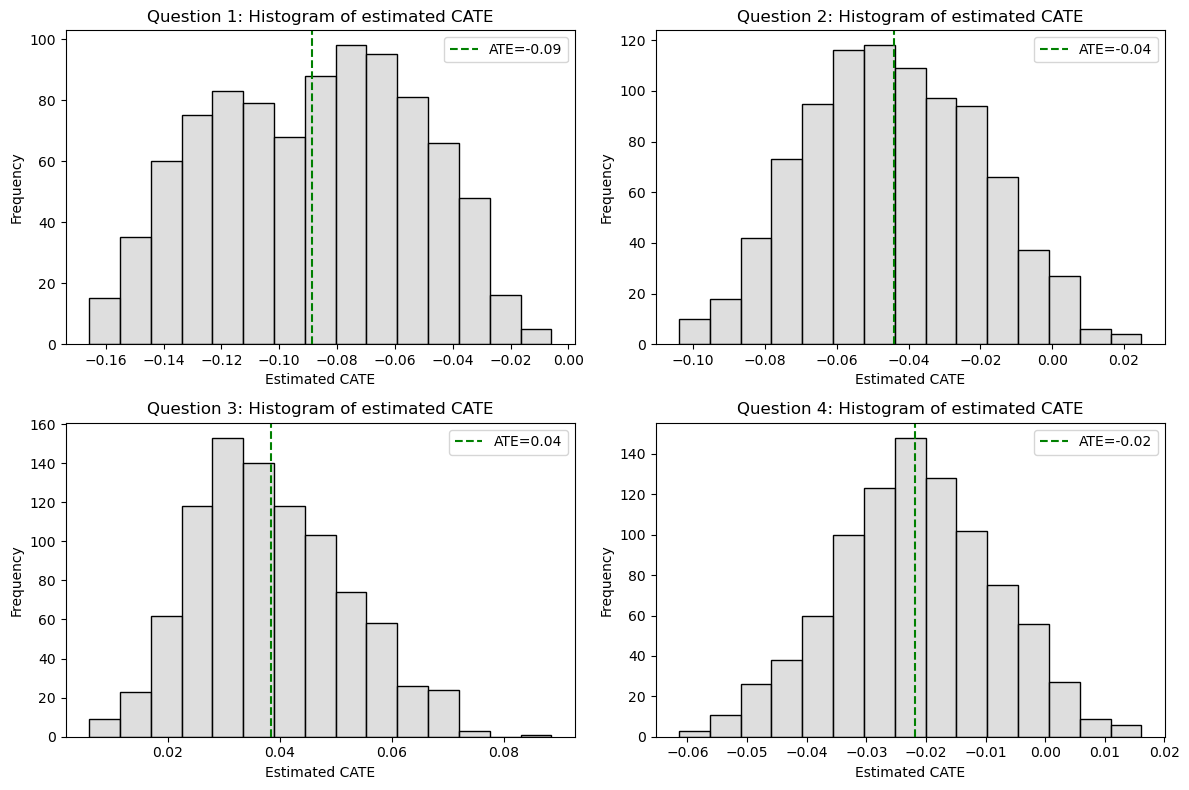

In [50]:
ate_1 = model_1_0.ate(x_cov)
ate_2 = model_2_0.ate(x_cov)
ate_3 = model_3_0.ate(x_cov)
ate_4 = model_4_0.ate(x_cov)

cate_1 = model_1_0.effect(x_cov)
cate_2 = model_2_0.effect(x_cov)
cate_3 = model_3_0.effect(x_cov)
cate_4 = model_4_0.effect(x_cov)

ate_list = [ate_1, ate_2, ate_3, ate_4]
cate_list = [cate_1, cate_2, cate_3, cate_4]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(4):
  sns.histplot(cate_list[i], bins=15, color='lightgray', edgecolor='black', ax=axes[i])
  axes[i].set_title(f'Question {i+1}: Histogram of estimated CATE')
  axes[i].set_xlabel("Estimated CATE")
  axes[i].set_ylabel("Frequency")
  axes[i].axvline(ate_list[i], color="green", linestyle="--", label=f'ATE={ate_list[i]:.2f}')
  axes[i].legend()

plt.tight_layout()
plt.show()

In [51]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

# yo necesito teoria para explicar pq este split puede ser 20/80 o 30/70
x_train_1, x_test_1, z_train_1, z_test_1, y_train_1, y_test_1 = train_test_split(x_cov, z_1, y_1, test_size=0.4, stratify=y_1, random_state= 2000)
x_train_2, x_test_2, z_train_2, z_test_2, y_train_2, y_test_2 = train_test_split(x_cov, z_2, y_2, test_size=0.4, stratify=y_2, random_state= 2000)
x_train_3, x_test_3, z_train_3, z_test_3, y_train_3, y_test_3 = train_test_split(x_cov, z_3, y_3, test_size=0.4, stratify=y_3, random_state= 2000)
x_train_4, x_test_4, z_train_4, z_test_4, y_train_4, y_test_4 = train_test_split(x_cov, z_4, y_4, test_size=0.4, stratify=y_4, random_state= 2000)


In [52]:
model_1 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_train_1, z_train_1, X=x_train_1)
model_1.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.112,0.026,-4.277,0.0,-0.163,-0.06
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.112,0.035,-3.198,0.001,-0.181,-0.043
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.111,0.039,-2.864,0.004,-0.187,-0.035


In [53]:
model_2 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_train_2, z_train_2, X=x_train_2)
model_2.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.045,0.027,-1.672,0.095,-0.098,0.008
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.048,0.037,-1.292,0.197,-0.12,0.025
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.043,0.039,-1.083,0.279,-0.12,0.035


In [54]:
model_3 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_train_3, z_train_3, X=x_train_3)
model_3.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,0.037,0.025,1.502,0.133,-0.011,0.086
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.032,0.037,0.854,0.393,-0.041,0.105
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.042,0.033,1.3,0.193,-0.022,0.106


In [55]:
model_4 = CausalForest(
    model_y=RandomForestRegressor(random_state=23),
    model_t=RandomForestClassifier(random_state=23),
    n_estimators=100,
    discrete_treatment=True,
    criterion="het",
    min_samples_leaf=10,
    max_samples=0.2,
    random_state=23
).fit(y_train_4, z_train_4, X=x_train_4)
model_4.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.006,0.022,-0.258,0.797,-0.048,0.037
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.027,0.032,-0.822,0.411,-0.09,0.037
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,0.015,0.029,0.532,0.595,-0.041,0.071


In [56]:
x_train_1_t = x_train_1.to_numpy()
x_test_1_t = x_test_1.to_numpy()
z_train_1_t = z_train_1.to_numpy()
z_test_1_t = z_test_1.to_numpy()
y_train_1_t = y_train_1.to_numpy()
y_test_1_t = y_test_1.to_numpy()

# ojo, hago esto porque me da error si tiene decimales diferentes el test....
x_train_1_t = np.round(x_train_1_t, 2)
x_test_1_t = np.round(x_test_1_t, 2)
z_train_1_t = np.round(z_train_1_t, 2)
z_test_1_t = np.round(z_test_1_t, 2)
y_train_1_t = np.round(y_train_1_t, 2)
y_test_1_t = np.round(y_test_1_t, 2)

x_train_2_t = x_train_2.to_numpy()
x_test_2_t = x_test_2.to_numpy()
z_train_2_t = z_train_2.to_numpy()
z_test_2_t = z_test_2.to_numpy()
y_train_2_t = y_train_2.to_numpy()
y_test_2_t = y_test_2.to_numpy()

x_train_2_t = np.round(x_train_2_t, 2)
x_test_2_t = np.round(x_test_2_t, 2)
z_train_2_t = np.round(z_train_2_t, 2)
z_test_2_t = np.round(z_test_2_t, 2)
y_train_2_t = np.round(y_train_2_t, 2)
y_test_2_t = np.round(y_test_2_t, 2)

x_train_3_t = x_train_3.to_numpy()
x_test_3_t = x_test_3.to_numpy()
z_train_3_t = z_train_3.to_numpy()
z_test_3_t = z_test_3.to_numpy()
y_train_3_t = y_train_3.to_numpy()
y_test_3_t = y_test_3.to_numpy()

x_train_3_t = np.round(x_train_3_t, 2)
x_test_3_t = np.round(x_test_3_t, 2)
z_train_3_t = np.round(z_train_3_t, 2)
z_test_3_t = np.round(z_test_3_t, 2)
y_train_3_t = np.round(y_train_3_t, 2)
y_test_3_t = np.round(y_test_3_t, 2)

x_train_4_t = x_train_4.to_numpy()
x_test_4_t = x_test_4.to_numpy()
z_train_4_t = z_train_4.to_numpy()
z_test_4_t = z_test_4.to_numpy()
y_train_4_t = y_train_4.to_numpy()
y_test_4_t = y_test_4.to_numpy()

x_train_4_t = np.round(x_train_4_t, 2)
x_test_4_t = np.round(x_test_4_t, 2)
z_train_4_t = np.round(z_train_4_t, 2)
z_test_4_t = np.round(z_test_4_t, 2)
y_train_4_t = np.round(y_train_4_t, 2)
y_test_4_t = np.round(y_test_4_t, 2)

In [57]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from econml.metalearners import TLearner
from econml.dml import DML

from econml.validate.drtester import DRTester


# Yo esto de por que escogen gradient o lo otro no lo entiendo... intentar entender

model_regression = RandomForestRegressor(random_state=23)
model_propensity = RandomForestClassifier(random_state=23)

## QUESTION 1

In [58]:
cf_tester = DRTester(
    model_regression=model_regression,
    model_propensity=model_propensity,
    cate=model_1
).fit_nuisance(x_test_1_t, z_test_1_t, y_test_1_t, x_train_1_t, z_train_1_t, y_train_1_t)

res_cf = cf_tester.evaluate_all(x_test_1_t, x_train_1_t, n_groups=2)
res_cf.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,3.602,1.388,0.01,0.022,0.008,0.004,0.069,0.027,0.005,0.386


<Axes: title={'center': 'Treatment = 1, Integral = 0.069 +/- 0.027'}, xlabel='Percentage treated', ylabel='Gain over Random'>

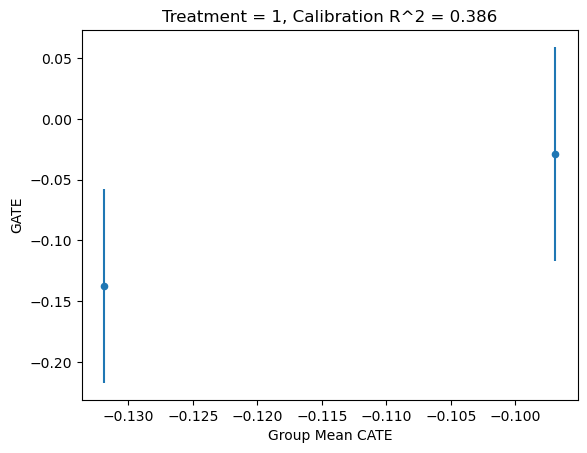

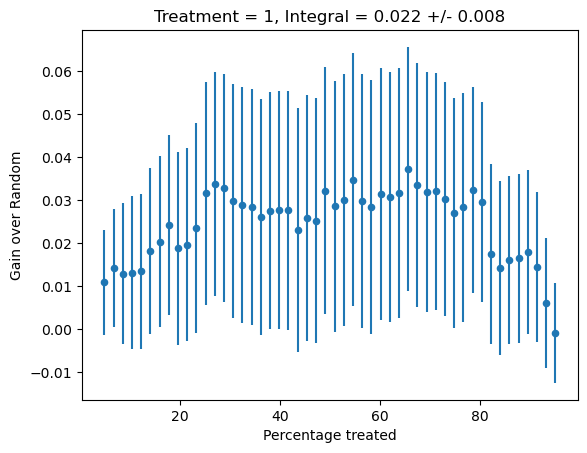

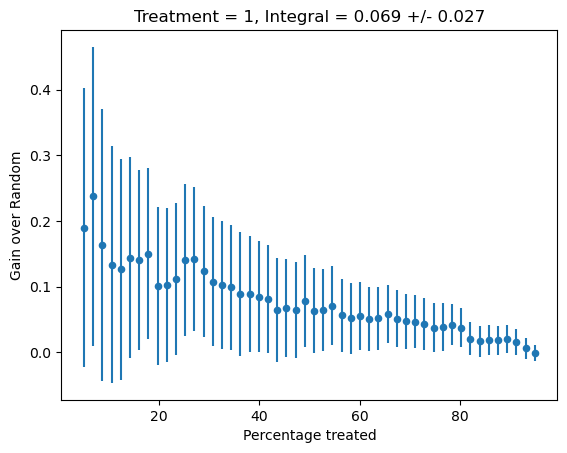

In [59]:
res_cf.plot_cal(1)
res_cf.plot_qini(1)
res_cf.plot_toc(1)

## QUESTION 2

In [60]:
cf_tester = DRTester(
    model_regression=model_regression,
    model_propensity=model_propensity,
    cate=model_2
).fit_nuisance(x_test_2_t, z_test_2_t, y_test_2_t, x_train_2_t, z_train_2_t, y_train_2_t)

res_cf = cf_tester.evaluate_all(x_test_2_t, x_train_2_t, n_groups=2)
res_cf.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,2.758,1.76,0.118,0.013,0.009,0.065,0.037,0.027,0.084,0.304


<Axes: title={'center': 'Treatment = 1, Integral = 0.037 +/- 0.027'}, xlabel='Percentage treated', ylabel='Gain over Random'>

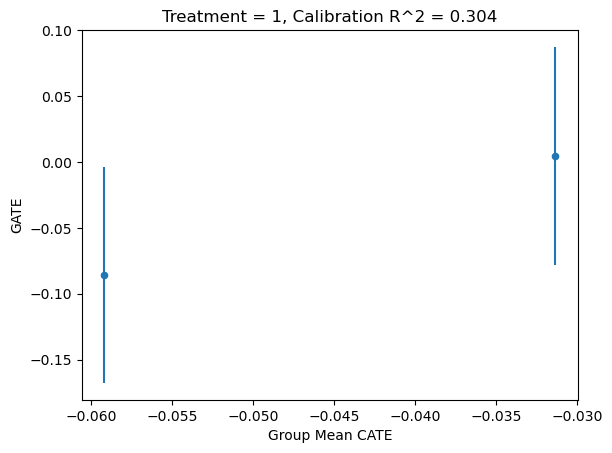

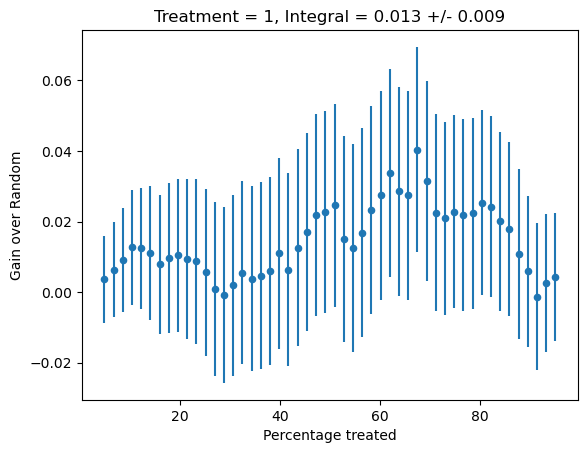

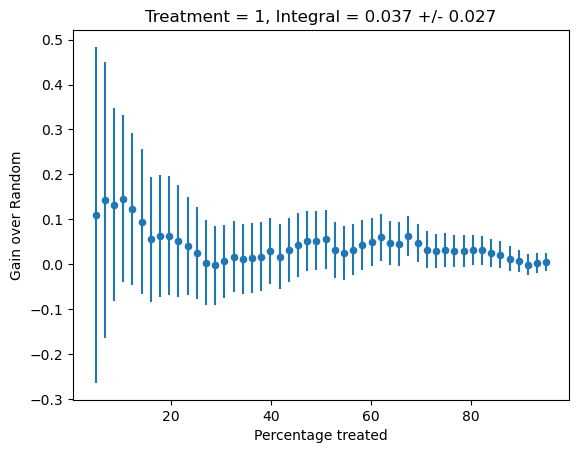

In [61]:
res_cf.plot_cal(1)
res_cf.plot_qini(1)
res_cf.plot_toc(1)

## QUESTION 3

In [62]:
cf_tester = DRTester(
    model_regression=model_regression,
    model_propensity=model_propensity,
    cate=model_3
).fit_nuisance(x_test_3_t, z_test_3_t, y_test_3_t, x_train_3_t, z_train_3_t, y_train_3_t)

res_cf = cf_tester.evaluate_all(x_test_3_t, x_train_3_t, n_groups=2)
res_cf.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,-0.814,2.033,0.689,-0.0,0.008,0.476,-0.004,0.024,0.426,-4.443


<Axes: title={'center': 'Treatment = 1, Integral = -0.004 +/- 0.024'}, xlabel='Percentage treated', ylabel='Gain over Random'>

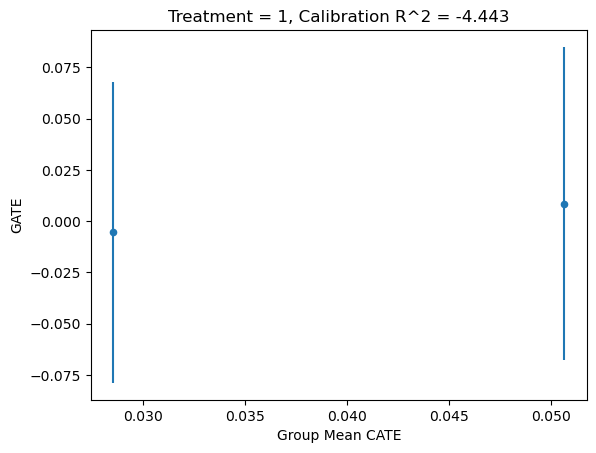

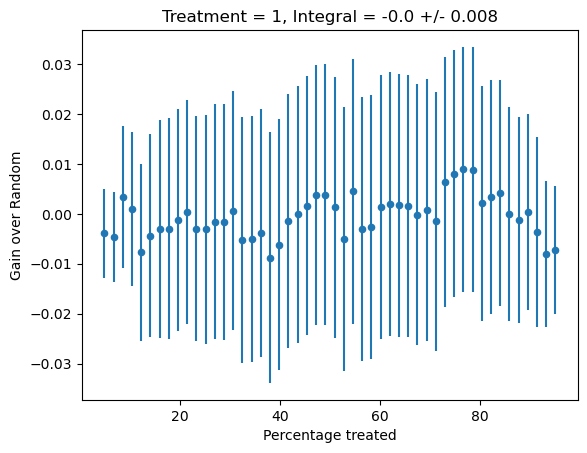

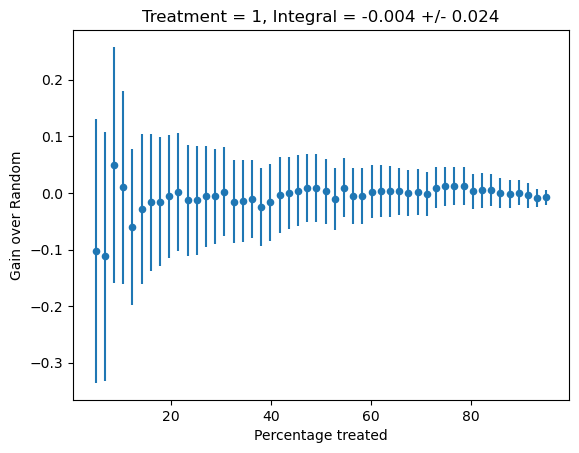

In [63]:
res_cf.plot_cal(1)
res_cf.plot_qini(1)
res_cf.plot_toc(1)

## QUESTION 4

In [64]:
cf_tester = DRTester(
    model_regression=model_regression,
    model_propensity=model_propensity,
    cate=model_4
).fit_nuisance(x_test_4_t, z_test_4_t, y_test_4_t, x_train_4_t, z_train_4_t, y_train_4_t)

res_cf = cf_tester.evaluate_all(x_test_4_t, x_train_4_t, n_groups=2)
res_cf.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,0.986,1.675,0.556,0.003,0.007,0.349,0.008,0.02,0.337,-1.384


<Axes: title={'center': 'Treatment = 1, Integral = 0.008 +/- 0.02'}, xlabel='Percentage treated', ylabel='Gain over Random'>

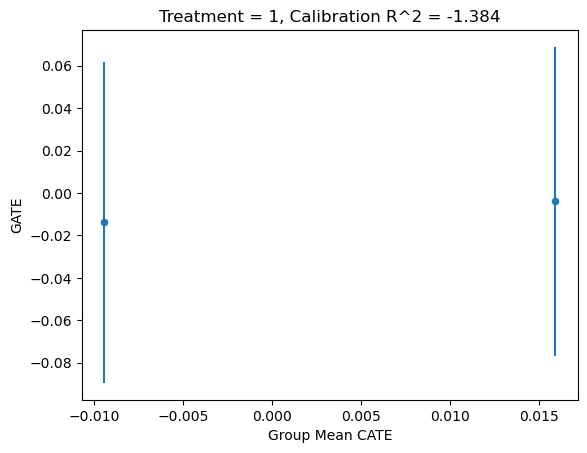

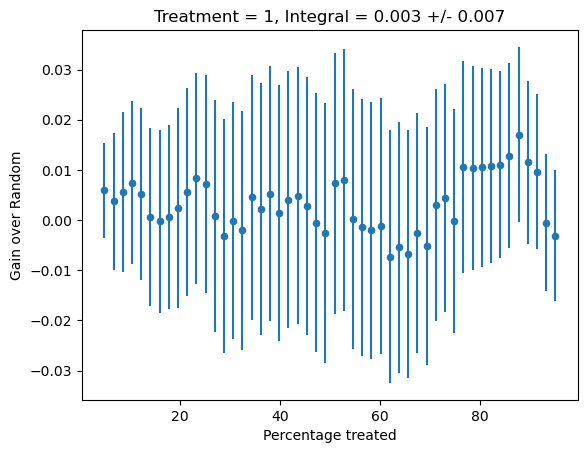

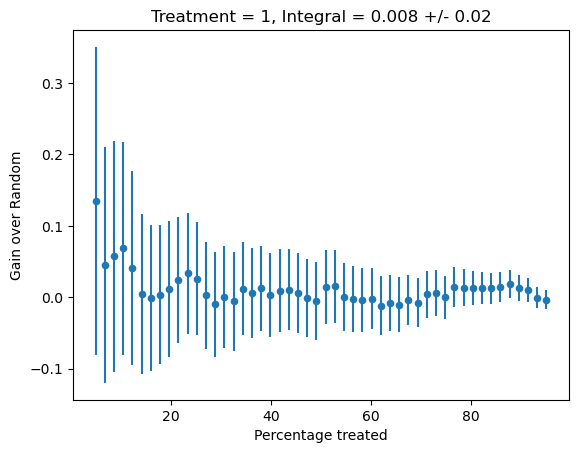

In [65]:
res_cf.plot_cal(1)
res_cf.plot_qini(1)
res_cf.plot_toc(1)

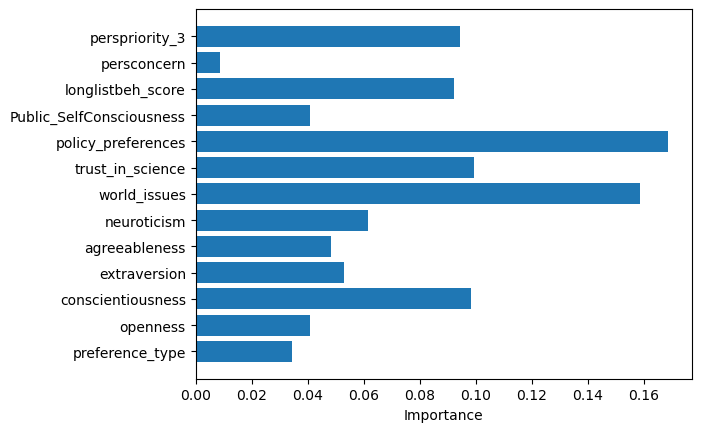

In [68]:
importances_2 = model_2.feature_importances_
features_2 = x_cov.columns
plt.barh(features_2, importances_2)
plt.xlabel("Importance")
plt.show()

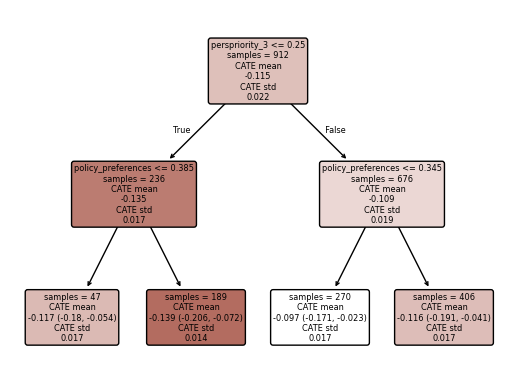

In [70]:
intrp_2 = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10, random_state=23)
intrp_2.interpret(model_1, x_cov)
intrp_2.plot(feature_names=list_with_extra_var)

In [1386]:
(data_1["attfail_w3"]==1).sum()


12

In [1387]:
rhs = sm.add_constant(data_1["attfail_w3"])
model = sm.OLS(data_1["Q1_1_treat"], rhs)
results = model.fit(cov_type="HC3")
    
print(f'Question {1}: {results.summary()}')

Question 1:                             OLS Regression Results                            
Dep. Variable:             Q1_1_treat   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2848
Date:                Mon, 23 Jun 2025   Prob (F-statistic):              0.594
Time:                        16:43:23   Log-Likelihood:                -661.76
No. Observations:                 912   AIC:                             1328.
Df Residuals:                     910   BIC:                             1337.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000      0.017     29.

In [ ]:
the_chosen_one = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism", 
                "world_issues", "trust_in_science", "policy_preferences", "Public_SelfConsciousness",
                "longlistbeh_score", "persconcern", "perspriority_3"]

In [1477]:
cate_1 = model_1_0.effect(x_cov)
cate_2 = model_2_0.effect(x_cov)

cate_median_1 = np.median(cate_1)
cate_median_2 = np.median(cate_2)

grupo_bajo_1 = cate_1 <= cate_median_1
grupo_alto_1 = cate_1 > cate_median_1
grupo_bajo_df_1 = data_1[grupo_bajo_1]
grupo_alto_df_1 = data_1[grupo_alto_1]

grupo_bajo_2 = cate_2 <= cate_median_2
grupo_alto_2 = cate_2 > cate_median_2
grupo_bajo_df_2 = data_1[grupo_bajo_2]
grupo_alto_df_2 = data_1[grupo_alto_2]

print("Q1")
print("Mean openness for group 1:", round(grupo_bajo_df_1["openness"].mean(), 2))
print("Mean openness for group 2:", round(grupo_alto_df_1["openness"].mean(), 2))
print("Mean conscientiousness for group 1:", round(grupo_bajo_df_1["conscientiousness"].mean(), 2))
print("Mean conscientiousness for group 2:", round(grupo_alto_df_1["conscientiousness"].mean(), 2))
print("Mean extraversion for group 1:", round(grupo_bajo_df_1["extraversion"].mean(), 2))
print("Mean extraversion for group 2:", round(grupo_alto_df_1["extraversion"].mean(), 2))
print("Mean agreeableness for group 1:", round(grupo_bajo_df_1["agreeableness"].mean(), 2))
print("Mean agreeableness for group 2:", round(grupo_alto_df_1["agreeableness"].mean(), 2))
print("Mean neuroticism for group 1:", round(grupo_bajo_df_1["neuroticism"].mean(), 2))
print("Mean neuroticism for group 2:", round(grupo_alto_df_1["neuroticism"].mean(), 2))


print("Q2")
print("Mean openness for group 1:", round(grupo_bajo_df_2["openness"].mean(), 2))
print("Mean openness for group 2:", round(grupo_alto_df_2["openness"].mean(), 2))
print("Mean conscientiousness for group 1:", round(grupo_bajo_df_2["conscientiousness"].mean(), 2))
print("Mean conscientiousness for group 2:", round(grupo_alto_df_2["conscientiousness"].mean(), 2))
print("Mean extraversion for group 1:", round(grupo_bajo_df_2["extraversion"].mean(), 2))
print("Mean extraversion for group 2:", round(grupo_alto_df_2["extraversion"].mean(), 2))
print("Mean agreeableness for group 1:", round(grupo_bajo_df_2["agreeableness"].mean(), 2))
print("Mean agreeableness for group 2:", round(grupo_alto_df_2["agreeableness"].mean(), 2))
print("Mean neuroticism for group 1:", round(grupo_bajo_df_2["neuroticism"].mean(), 2))
print("Mean neuroticism for group 2:", round(grupo_alto_df_2["neuroticism"].mean(), 2))


Mean age for group 1: 0.56
Mean age for group 2: 0.57
